##                                                    CLOSETTE AI MODEL 

In [1]:
# IMPORTING THE DATASET

import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset
data_dir = 'D:\DATA SCIENCE\CLOSET APP\DATASET'
images_folder = os.path.join(data_dir, 'images')
styles_path = os.path.join(data_dir, 'styles.csv')


In [7]:
df = df[df['id'].apply(lambda x: os.path.isfile(os.path.join(images_folder, str(x) + '.jpg')))]
df['image'] = df['id'].apply(lambda x: os.path.join(images_folder, str(x) + '.jpg'))

In [8]:

# Focus on the 'subCategory' column
df = df[['image', 'subCategory']]

# Count the DFnumber of samples in each category
category_counts = df['subCategory'].value_counts()
print(category_counts)

# Filter categories with at least 800 samples
valid_categories = category_counts[category_counts >= 800].index

# Filter the dataframe to include only valid categories
df = df[df['subCategory'].isin(valid_categories)]

# Split data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.1, stratify=df['subCategory'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['subCategory'], random_state=42)

subCategory
Topwear                     15398
Shoes                        7343
Bags                         3055
Bottomwear                   2693
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Headwear                      293
Ties                          258
Accessories                   129
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    104
Stoles                         90
Skin Care                      77
Sk

In [9]:
# Data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,        
    width_shift_range=0.1,   
    height_shift_range=0.1,   
    shear_range=0.1,
    zoom_range=0.1,          
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)  # No augmentation for test set

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='subCategory',
    target_size=(160, 120), 
    batch_size=64,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image',
    y_col='subCategory',
    target_size=(160, 120),  
    batch_size=64,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='subCategory',
    target_size=(160, 120),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

Found 35659 validated image filenames belonging to 13 classes.
Found 1981 validated image filenames belonging to 13 classes.
Found 1982 validated image filenames belonging to 13 classes.


In [10]:
# Create a custom CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(160, 120, 3)),
    BatchNormalization(), 
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)), 
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5), 
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Callbacks for improved training
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights  # Adding class weights
)


model.save('model.keras')

Epoch 1/25
558/558 [==============================] - 1311s 2s/step - loss: 2.4732 - accuracy: 0.6118 - val_loss: 2.0773 - val_accuracy: 0.6259 - lr: 1.0000e-04
Epoch 2/25
558/558 [==============================] - 1180s 2s/step - loss: 1.9357 - accuracy: 0.7091 - val_loss: 1.6952 - val_accuracy: 0.8385 - lr: 1.0000e-04
Epoch 3/25
558/558 [==============================] - 1381s 2s/step - loss: 1.7330 - accuracy: 0.7516 - val_loss: 1.3882 - val_accuracy: 0.8900 - lr: 1.0000e-04
Epoch 4/25
558/558 [==============================] - 1223s 2s/step - loss: 1.5934 - accuracy: 0.7744 - val_loss: 1.2511 - val_accuracy: 0.9016 - lr: 1.0000e-04
Epoch 5/25
558/558 [==============================] - 1086s 2s/step - loss: 1.4670 - accuracy: 0.7891 - val_loss: 1.1920 - val_accuracy: 0.9056 - lr: 1.0000e-04
Epoch 6/25
558/558 [==============================] - 1029s 2s/step - loss: 1.3625 - accuracy: 0.8075 - val_loss: 1.3915 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 7/25
558/558 [==============

31/31 [==============================] - 39s 1s/step - loss: 0.6941 - accuracy: 0.9495
Test Loss: 0.6941
Test Accuracy: 94.95%


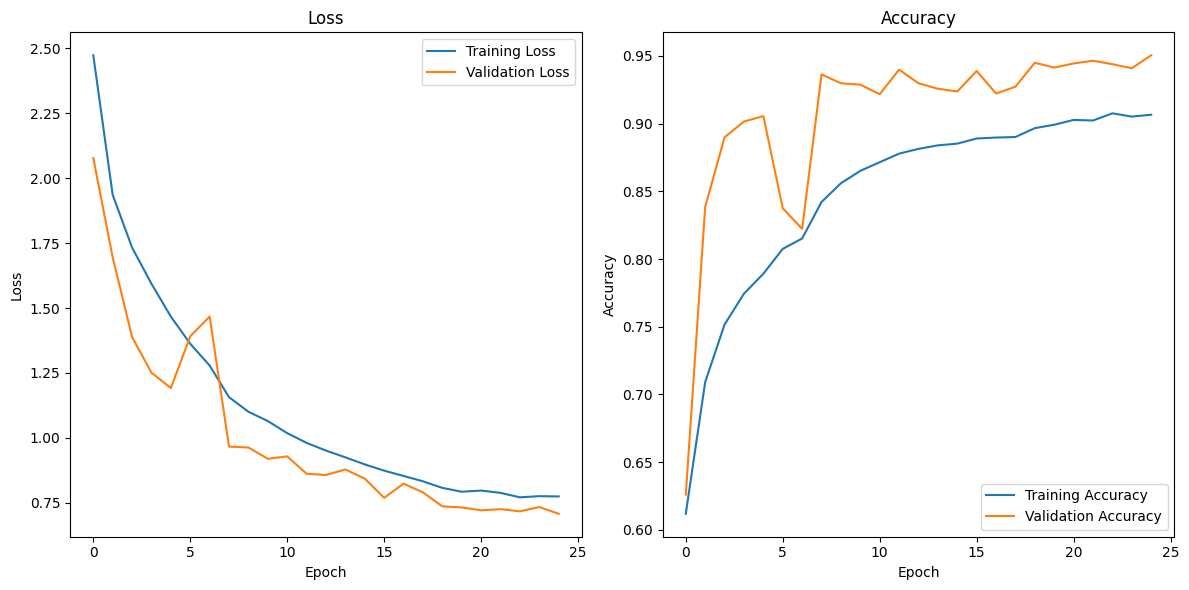

31/31 [==============================] - 8s 261ms/step
Classification Report:
              precision    recall  f1-score   support

        Bags       0.86      0.95      0.90       153
       Belts       1.00      0.85      0.92        40
  Bottomwear       0.94      0.99      0.96       135
     Eyewear       0.93      1.00      0.96        54
  Flip Flops       0.74      0.93      0.82        45
   Fragrance       0.98      0.90      0.94        51
   Innerwear       0.95      0.95      0.95        91
   Jewellery       0.79      0.96      0.87        54
      Sandal       0.90      0.58      0.71        48
       Shoes       0.95      0.95      0.95       368
     Topwear       0.99      0.98      0.98       770
     Wallets       0.91      0.87      0.89        46
     Watches       0.99      0.97      0.98       127

    accuracy                           0.95      1982
   macro avg       0.92      0.91      0.91      1982
weighted avg       0.95      0.95      0.95      1982



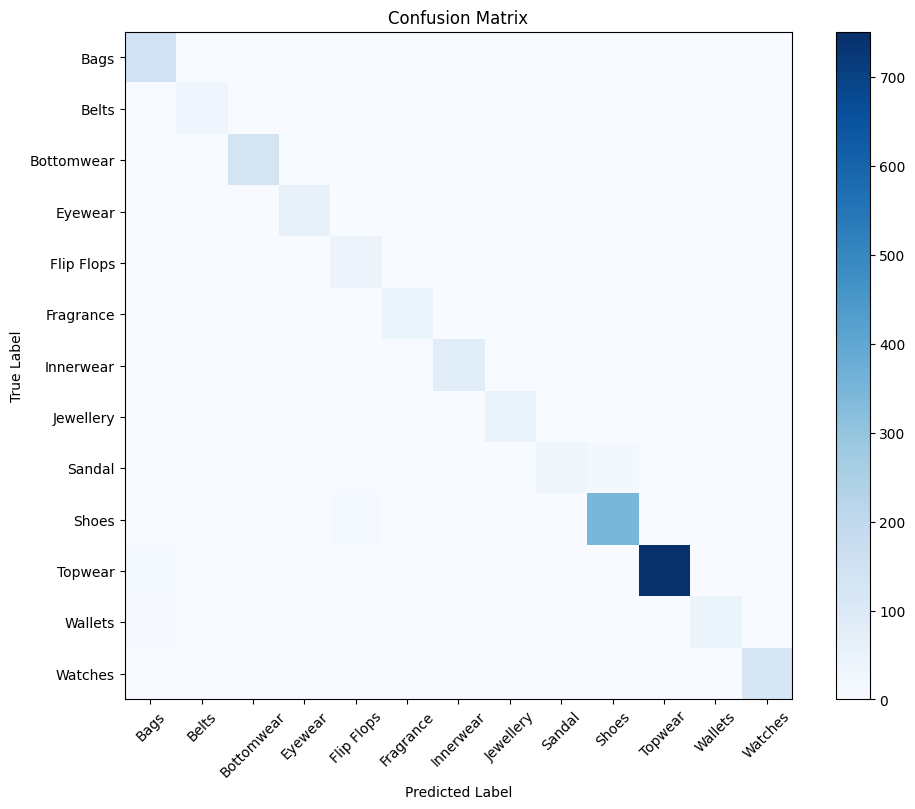

In [11]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plotting training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Predicting on Test Set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true classes and class labels
true_classes = test_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Classifing Report
print("Classification Report:")
print(classification_report(true_classes, y_pred, target_names=class_labels))

# Checking - Confusion Matrix
conf_matrix = confusion_matrix(true_classes, y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

In [12]:
print(class_labels)

['Bags', 'Belts', 'Bottomwear', 'Eyewear', 'Flip Flops', 'Fragrance', 'Innerwear', 'Jewellery', 'Sandal', 'Shoes', 'Topwear', 'Wallets', 'Watches']


In [13]:
model.save('H_CLOSET_MODEL.h5')